# 图像识别
## 回顾和学习的必要条件
上一个项目我们尝试使用全互联(Fully connected)的神经网络识别手写数字。我们学习了，
1. 监督学习(supervised learning)的概念，训练(training)和推倒(inference)
2. 人工神经网络(artificial neural networks, ANN)
3. 用Tensorflow library构造机器学习的应用程序
4. Tensorflow build 是图形化的工具，用来生成ANN网络架构
5. 怎样用jupyter notebook玩转数据集(dataset)
为了能够充分理解这个项目，我们假定你，
1. 理解了以前的项目，尤其是神经网络的基本原理和tensorflow
2. 理解基本的程序设计，能够读懂一些简单的python程序
3. 理解numpy的基本使用，如何表示多维数组等
4. 如果你并不具备以上，你也可以继续浏览。只需记住jupyter生存指南，_用“Control+空格键”执行程序格子并依照顺序下行即可_。所有已经执行过的程序格子会在左上角标识执行顺序号。
````
In [1]:
````

尚未执行的格子序号为空白。

更多的Jupyter 生存经验可以从 https://www.cheatography.com/weidadeyue/cheat-sheets/jupyter-notebook/ 找到。


## 图像物体识别
在这一个项目中，我们尝试图像识别。CIFAR 10 是一个常用的图像数据库。包含60,000个32x32的图像。分成10 个类别。更详细的信息请参考https://www.cs.toronto.edu/~kriz/cifar.html 。 这个数据集比较小，训练速度比较快。但在应用中，32x32的图像并不很实用。以后的项目中我们将学习更复杂的model 和dataset，比如imagenet。和上一个项目一样，我们进行监督学习，任务是接受一个单一物体的图像，神经网络输出图像的类别。如下图所示，

<img src="static/project-1.png", width=300, height=300>

## 了解我们的数据
在machine learning的项目里，首先要做的就是了解我们的数据。数据的采集整理往往会花费多余实际学习的时间。所以让我们马上开始研究数据，首先import常用的软件包(package)，

In [1]:
from ipywidgets import widgets, interact, interactive, fixed, interact_manual
import os
import random
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import time
import glob

设置一个用户名(Chris)，将来我们设计网络的时候会用到。

In [2]:
user = 'chris'

下面这一段javascript代码用来找到服务器地址，如果你不理解的话也不用担心。

In [3]:
%%javascript
var kernel = IPython.notebook.kernel;
var command = ["currenturl = ", "'", window.location.href, "'" ].join('')
kernel.execute(command)

<IPython.core.display.Javascript object>

In [4]:
from urllib.parse import urlparse
o = urlparse(currenturl)
hostname = o.hostname
print("This is the server address {}".format(hostname))

This is the server address 192.168.0.107


前面提到，CIFAR 10 数据集由10类共60,000个图像组成，每一个类别中正好有6000个图像，每一个图像是32x32大小。他们存储成3x32x32 = 3072字节的固定长记录，其中我们用3个channel分别表示Red, green, black的颜色强度。另外，我们用一个字节编码图像类别(从0到9)。他们被加在每一个记录的最前面。
<img src="static/cifar.png", width=200, height=200>
所有60,000个图片被压在一起并分成5个文件。用shell命令列表如下，

In [5]:
!ls cifar-10/*.bin

cifar-10/data_batch_1.bin  cifar-10/data_batch_3.bin  cifar-10/data_batch_5.bin
cifar-10/data_batch_2.bin  cifar-10/data_batch_4.bin  cifar-10/test_batch.bin


下面这一小段程序读入所有的数据集，并作为numpy数组存放到images和label变量中。我们验证一共有60,000个图像记录。

In [6]:
cifarpath = os.path.join('cifar-10', "*.bin")
size           = 32
color_channels = 3
image_size     = size * size * color_channels
label_size     = 1
raw_size       = image_size + label_size
inputraw       = []
labelsraw      = []
for cifarbinname in glob.glob(cifarpath):
    with open(cifarbinname, 'rb') as cifarfile:
        raw = cifarfile.read()
        n_images = len(raw) // raw_size
        offset = 0
        for i in range(n_images):
            single = np.frombuffer(raw, dtype=np.uint8, count=image_size, offset=offset + label_size)
            labelsraw.append(raw[offset])
            inputraw.append(single)
            offset += raw_size
print("TOTAL {} images".format(len(inputraw)))
images_ = np.stack(inputraw, axis = 0).reshape([-1, color_channels, size, size])
labels_ = np.array(labelsraw, dtype=np.int32)

TOTAL 60000 images


另外，我们读入metadata文件，里面存有每个label所表示的物体，

In [7]:
with open(os.path.join('cifar-10', 'batches.meta.txt'), 'r') as metafile:
    lines = metafile.readlines();
label_text = [x.strip() for x in lines]
print('Objects: {}'.format(label_text))
nlabels = len(label_text)
nimages = images_.shape[0]

Objects: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


原始数据中，我们把三个颜色平面叠加在一起的数组形状是
````
[60000,3,32,32]
````
为方便显示图像我们需要将颜色移动到最后，变成，
````
[60000,32,32,3]
````
的形状。这种操作叫transpose，它在numpy library中有直接的支持，

In [8]:
images_reshaped = images_.transpose([0,2,3,1])
print('shape of images = {}, shape of transposed images = {}'.format(images_.shape, images_reshaped.shape))

shape of images = (60000, 3, 32, 32), shape of transposed images = (60000, 32, 32, 3)


下面我们从每一个类别中，随机选取5张显示。下面的程序片段可以做到，你也可以多运行几遍 （用Control+Enter)，每次都将得到不同的图片。你是不是已经对数据集和我们的数据加载过程有信心了呢？注意computer会花一些时间思考，在思考的时候，程序框左上角的 In [ ] 中会显示星号。你能够识别每一个图像吗？我们项目结尾有一个人和AI比赛识别的小竞赛来比比你还是你的AI的水平高。

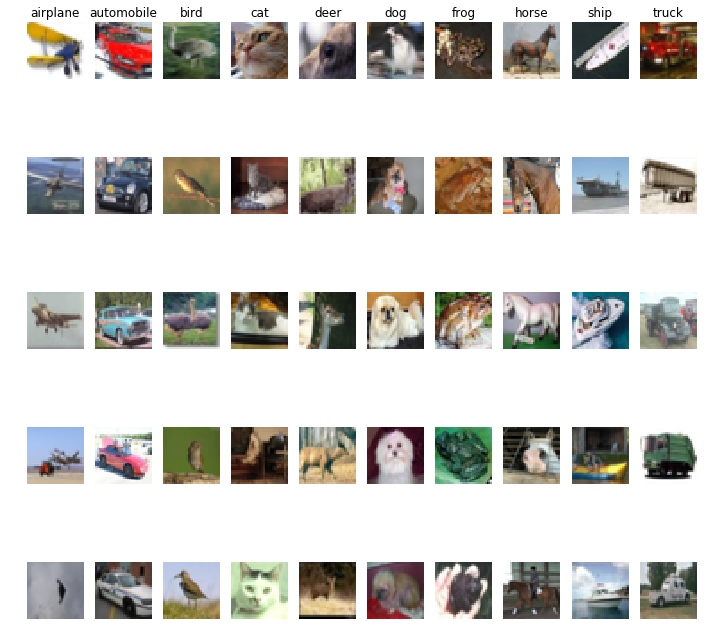

In [9]:
sort_index = np.argsort(labels_)
images_sorted = images_reshaped[sort_index]
labels_sorted = labels_[sort_index]
plt.figure(figsize=(12,12))
images_per_category = nimages // nlabels

samples = 5
for i in range(nlabels):
    for j in range(samples):
        index = random.randint(0, images_per_category - 1)
        plt.subplot(samples, nlabels, j * nlabels + i + 1)
        plt.axis('off')
        plt.xlabel("")
        plt.ylabel("")
        plt.imshow(images_sorted[i * images_per_category + index], interpolation='nearest')
        if (j == 0):
            plt.title(label_text[labels_sorted[i * images_per_category + index]])
plt.show()

作为调试，下面的display_images_and_labels能够显示任意的图形和类别。传入参数为图形数组和类别数组，加上要显示图形的个数。你不妨试试，

In [10]:
def display_images_and_labels(images, labels, numbers):
    x = list(range(labels.size))
    random.shuffle(x)
    img_ = images[x]
    lbl_ = labels[x]
    for i in range(numbers):
        plt.figure(figsize=(6,6))
        plt.subplot(numbers, 1, i + 1)
        plt.axis('off')
        plt.xlabel("")
        plt.ylabel("")
        plt.imshow(img_[i], interpolation='nearest')
        plt.title(label_text[lbl_[i]])
        plt.show()

以前的项目中提到过，在机器学习算法中，我们往往需要打乱数据集的原有顺序（洗牌）。原因是因为我们的数据量太大，需要分批训练(minibatch),如果每一批数据的规律性很强，如他们来自一个类别，则训练的时候误差会不一致造成训练时间过长（或效果不佳）。下面一段洗牌代码打乱了数据集的顺序。更好的方法是在每次训练遍历之前都重新洗牌(但这个项目中没有这样做)。别忘记洗牌图片的是后还要按照同样的顺序重排类别数据，否侧会造成数据不一致，最好的办法是用上面的display_images_and_labels显示几个结果，保证数据的一致性。

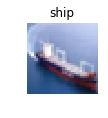

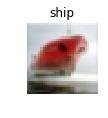

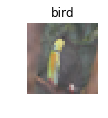

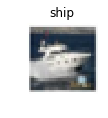

In [11]:
def shuffle_images(images, labels):
    x = list(range(images_reshaped.shape[0]))
    random.shuffle(x)
    return images_reshaped[x], labels[x]
images, labels = shuffle_images(images_reshaped, labels_)
display_images_and_labels(images, labels, 4)

下面，我们把数据集分为训练集和测试集(training set and test set)两部分。必须注意在机器学习项目中，我们必需保证在训练的时候只用训练集，不要去碰测试集，因为以后提到的overfitting的问题，我们的模型往往用在训练集之上准确性更高。如果训练中用到了测试集，就会象做作业时先看答案后解题一样，失去了实际training的意义。我们现在分出50,000个图片作为训练集，剩下的10,000个图片作为测试集。

In [12]:
train2test_ratio = 6
test_size  = images.shape[0] // train2test_ratio
train_size = nimages - test_size
train_images, test_images = np.split(images, [train_size])
train_labels, test_labels = np.split(labels, [train_size])
print("train_images shape = {} train_labels shape = {} test_images shape = {} test_labels shape = {}".format(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape))

train_images shape = (50000, 32, 32, 3) train_labels shape = (50000,) test_images shape = (10000, 32, 32, 3) test_labels shape = (10000,)


再一次，如果不肯定的话，用display_images_and_labels去显示训练集和测试集，保证图片和类别标号的一致性。

## 设计Deep network 的架构

### 什么是CNN

CNN(Convolutional Neural Networks)是一种特殊的神经元组件。我们在手写识别的项目中使用的是全互联网络。全互连网把每层的节点和他下家的节点全部连接起来，导致计算量成倍增加。然而我们发现，在图像识别的例子中，全互联是不是一种很合理的策略。比如，图像坐下脚的像素和右上角的像素本来没有什么关系，全互联网络导致computer花费不必要的努力去开发这些不相关节点的“关系”。可以从下图感觉一下全互联网络的复杂性，你能数出（算出）网络中一共有多少连线吗？
<img src="static/fully-connected-1.png", width=300, height=300>
在这个理解基础上，我们使用一种特殊的网络层，只把画面中相邻的点互联起来，比如说一个方块中的点。因为临近的点才有可能表达一种关联的食物。比如人的眉毛，眼睛和脸部。我们把这种CNN层想象成一个滤镜。在训练中，我们设计大量的滤镜。我们希望computer自动学习到一些图像的特征。比如有的滤镜成为眉毛滤镜，有的识别眼睛等等。底层的滤镜们识别图形细节，高层的滤镜识别整体，例如脸部，整个人体等。CNN算法用滤镜扫描整个目标图形，如下所示，
<img src="static/convolution-1.png", width=300, height=300>
在扫描过程中，接近滤镜的物体将被激活。这样，整个图形会在多层神经激活链中被识别。下面的图是一个基于cnn的网络构架，左边是CNN层（底层），他们负责识别物体的特征。右边是全互联层，负责识别高层物品（或他们的关系）。
<img src="static/cnn-1.png", width=300, height=300>
我们可以把CNN想成一个方块。正面是滤镜，厚度则是滤镜的数量（多滤镜）。与之对应的全互联层测是一条穿过珠子的先。你注意到CNN保持了图形的本身结构，而全互联先把图形“拉”成一条直线，再开始学习。
### Pooling 层
TODO
<img src="static/MaxPool.png", width=300, height=300>

CNN网络的另一种组件是Pooling层。我们在CNN滤镜扫描的时候，如果一次移动一个像素(stride为1)，并且在边上填充的时候，得到的输出结果与原来图形长宽是一样的。高清晰度照片将会产生大量的计算。我们将插入一些Pooling层，把相邻滤镜的像素点压缩到一点上。这样会减少计算量。
### CIFAR 数据集的架构
CIFAR 数据集的架构如下，网络是有底层的Convolutional 层和Pooling层组成的。高层则由我们熟悉的全互联组成。我们可以用Tensor builder来观察或改进该架构。注意网络中的LOCAL response normalization 层，我们以后会介绍。网络最后输出10个节点，每一个用来表示一种物体类别。

In [13]:
from IPython.display import display, HTML
url = "<iframe src=http://" + hostname + ":8080/?user=" + user + " width=850 height=650></iframe>"
HTML(url)

In [14]:
modelfile = os.path.join('model', user + '.py')

我们自动生成的模型描述如下，

In [18]:
# %load model/chris.py
def model(net):

    net = tf.contrib.layers.conv2d(net, 64, [5,5], 1, activation_fn = tf.nn.relu, padding='SAME', scope='conv2')

    net = tf.contrib.layers.max_pool2d(net, [3, 3], 2, padding='SAME', scope='pool3')

    net = tf.nn.lrn(net, 4, bias = 1.00, alpha = 0.0001, beta = 0.750, name = 'lrn4')

    net = tf.contrib.layers.conv2d(net, 64, [5,5], 1, activation_fn = tf.nn.relu, padding='SAME', scope='conv5')

    net = tf.nn.lrn(net, 4, bias = 1.00, alpha = 0.0001, beta = 0.750, name = 'lrn6')

    net = tf.contrib.layers.max_pool2d(net, [3, 3], 2, padding='SAME', scope='pool7')

    net = tf.contrib.layers.flatten(net, scope='flatten8')
    net = tf.contrib.layers.fully_connected(net, 384, activation_fn=tf.nn.relu, scope='fc9')

    net = tf.contrib.layers.fully_connected(net, 192, activation_fn=tf.nn.relu, scope='fc10')

    net = tf.contrib.layers.fully_connected(net, 10, activation_fn=None, scope='fc11')
    return net


现在加入整个网络的输入输出，训练的Loss，得到最后的tensorflow模型描述，你不需要理解所有的细节，最重要的是self.probability输出是个数量，每一个表示图片是该物体的可能性。而self.train是一个training的机制。我们反复的调用training机器，每次喂给它不同的数据，它会不断地调整模型参数，逐渐减少图像识别的错误，我们的目标是通过调用self.train来减少self.loss。

In [19]:
class Network:
    def __init__(self):
        self.input = tf.placeholder(dtype = tf.int32, shape = [None, size, size, color_channels], name = "input")
        self.label = tf.placeholder(dtype = tf.int32, shape = [None], name = "label")
        self.image = tf.placeholder(dtype = tf.int32, shape = [size, size, color_channels])
        image = tf.cast(self.image, tf.float32)
        self.standadize = tf.image.per_image_standardization(image)
        self.randomize = tf.image.random_flip_left_right(image)
        self.randomize = tf.image.random_brightness(self.randomize, max_delta = 63)
        self.randomize = tf.image.random_contrast(self.randomize, lower=0.2, upper=1.8)
        self.randomize = tf.image.per_image_standardization(self.randomize)
        input_converted = tf.cast(self.input, tf.float32)
        self.logits = model(input_converted)
        self.probability = tf.nn.softmax(self.logits, name = "probability")
        losses = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = self.label, logits = self.logits, name = 'losses')
        self.loss = tf.reduce_mean(losses, name = 'loss')
        optimizer = tf.train.RMSPropOptimizer(0.0003)
        self.train = optimizer.minimize(self.loss, global_step = tf.contrib.framework.get_global_step())
        tf.summary.scalar('loss', self.loss)
        for s in tf.trainable_variables():
            if 'weights' in s.name:
                tf.summary.histogram(s.name, s)
            if 'biases' in s.name:
                tf.summary.histogram(s.name, s)

我们现在生成网络，你可能会看到一些输出信息，我们可以不用管。

In [20]:
tf.contrib.framework.get_or_create_global_step()
network = Network()

INFO:tensorflow:Summary name conv2/weights:0 is illegal; using conv2/weights_0 instead.
INFO:tensorflow:Summary name conv2/biases:0 is illegal; using conv2/biases_0 instead.
INFO:tensorflow:Summary name conv5/weights:0 is illegal; using conv5/weights_0 instead.
INFO:tensorflow:Summary name conv5/biases:0 is illegal; using conv5/biases_0 instead.
INFO:tensorflow:Summary name fc9/weights:0 is illegal; using fc9/weights_0 instead.
INFO:tensorflow:Summary name fc9/biases:0 is illegal; using fc9/biases_0 instead.
INFO:tensorflow:Summary name fc10/weights:0 is illegal; using fc10/weights_0 instead.
INFO:tensorflow:Summary name fc10/biases:0 is illegal; using fc10/biases_0 instead.
INFO:tensorflow:Summary name fc11/weights:0 is illegal; using fc11/weights_0 instead.
INFO:tensorflow:Summary name fc11/biases:0 is illegal; using fc11/biases_0 instead.


下面的代码用来初始化tensorflow session。并且建立相应的tensorflow统计信息，用在将来的tensorboard信息板上，

In [21]:
saver = tf.train.Saver()
saver_path = os.path.join('saved_models', user)
if not os.path.exists(saver_path):
    os.makedirs(saver_path)
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())
session = tf.Session()
session.run(init_op)
summary_path = os.path.join('summary', user)
if not os.path.exists(summary_path):
    os.makedirs(summary_path)
summary_writer = tf.summary.FileWriter(summary_path, session.graph)
merged = tf.summary.merge_all()

restore 和 save 用来回复和存贮模型训练的参数。下次重新运行程序的时候可以在上次的基础上进一步训练，或用已经产生的模型参数直接进行推倒。我们暂时不用这两个功能。

In [22]:
def restore(session, saver, path):
    print(path)
    checkpoint = tf.train.latest_checkpoint(path)
    if checkpoint:
        saver.restore(session, checkpoint)
        steps = session.run(tf.contrib.framework.get_global_step())
        print("restored model @ steps {}".format(steps))

In [23]:
def save(session, saver, path):
    steps = session.run(tf.contrib.framework.get_global_step())
    p = os.path.join(path, user)
    saver.save(session, p, steps)
    print("saved model @ steps {}".format(steps))

在deep learning中，我们往往需要很多的数据, 比如Imagenet数据集有上百万个图片。相比之下，我们的CIFAR10只有五万个图像。在数据不够的情况下，训练出来的神经网络往往会“记住”数据和答案，而不是学习到真正的知识。就像你在考试之前如果被告知题目范围的话（数据量不够大），你可以把所有题目都背下来。神经网络也是一样。为了让它能够学到真正的知识，我们在数据不够的情况下，往往可以发挥我们对图像的知识，用现有的数据自动生成新的图片，比如，
1. 把图片倒过来，应该还是原来的物体。（有例外吗？）
2. 把图片加亮。
3. 把图片对比度提高。
我们可以用这些方法扩大数据量，来满足神经网络对数据的饥渴。下面的代码randomize_batch就是用来完成这些图像变形的。你先在不用理解standadize_batch，我们以后会进一步提到。

In [24]:
def standadize_batch(images):
    size = images.shape[0]
    acc = []
    for i in range(size):
        with tf.device('/cpu:0'):
            processed, = session.run([network.standadize], feed_dict = {network.image : images[i]})
            acc.append(processed)
    post = np.stack(acc, axis = 0)
    return post
def randomize_batch(images):
    size = images.shape[0]
    acc = []
    for i in range(size):
        with tf.device('/cpu:0'):
            processed, = session.run([network.randomize], feed_dict = {network.image : images[i]})
            acc.append(processed)
    post = np.stack(acc, axis = 0)
    return post

我们用下面的代码片段来预测随机的图片。运行后，AI机器预测图像属于每种物体的可能性。现在系统还没有学习过。我们可以运行几次，看看AI有几次猜对。

<a id="inference"></a>

cat        34.05%
ship       30.27%
dog        19.84%
bird       4.98%
horse      2.65%
airplane   2.51%
truck      2.00%
frog       1.78%
deer       1.55%
automobile 0.39%


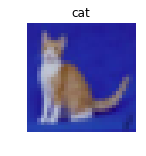

In [78]:
plt.figure(figsize=(2,2))
plt.subplot(1, 1, 1)
plt.axis('off')
plt.xlabel("")
plt.ylabel("")
x = random.randint(0, test_size - 1)
img = test_images[x]
lbl = test_labels[x]
img_standadized = np.expand_dims(img, axis=0)
img_standadized = standadize_batch(img_standadized)
probability, = session.run([network.probability], feed_dict = {network.input : img_standadized})
probability = np.reshape(probability,[-1])
x = np.argsort(probability)
for i in range(nlabels-1,-1,-1):
    print("{:10s} {:.2f}%".format(label_text[x[i]], probability[x[i]] * 100.0))
plt.imshow(img, interpolation='nearest')
plt.title(label_text[lbl])
plt.show()

现在我们来开始训练网络。我们首先打开tensorboard, 在SCALARS标签下，打开loss_1, 你可以观察到训练的进程。你会发现loss_1 逐渐递减接近零。loss越小，表明我们的预测越接近ground truth。首先你需要清除以前的日志记录。

In [29]:
!ls summary/chris
!rm -f summary/chris/*

events.out.tfevents.1500955533.iceberg


In [30]:
url = "<iframe src=http://" + hostname + ":6006" + " width=850 height=650></iframe>"
HTML(url)

开始训练，先运行一遍。通常我们需要反复运行所有的数据很多遍来得到更高的预测精确率。如果有时间，你可以反复训练多次，或者增加epoch。如果在CPU上运行一遍可能要好几十分钟。在现代的GPU上只需少于一分钟时间。

In [56]:
batch_size = 128
epochs = 1

for epoch in range(epochs):
    print("EPOCH {}".format(epoch + 1))
    randomized_image = randomize_batch(train_images)
    processed = 0
    loss_acc = 0
    total_trainings = 0
    
    while processed < train_size:
        last = processed + batch_size
        if last > train_size:
            last = train_size
        summary_step, _, loss_step, steps = session.run([merged, network.train, network.loss, tf.contrib.framework.get_global_step()],
                                                       feed_dict = {network.input : randomized_image[processed:last],
                                                                    network.label : train_labels[processed:last]})
        loss_acc += loss_step
        total_trainings += 1
        if total_trainings % 100 == 0:
            print("processed = {}".format(processed))
            summary_writer.add_summary(summary_step, steps)
        processed = last
    print("EPOCH {} DONE AVERAGE LOSS = {:.2f}".format(epoch + 1, loss_acc / total_trainings))

EPOCH 1
processed = 12672
processed = 25472
processed = 38272
EPOCH 1 DONE AVERAGE LOSS = 1.11


你可以回到[inference](#inference)，实验一下经过训练，AI的预测是不是更准确了。或者用下面的代码段来测试所有的test图像。代码段输出预测的准确率。

In [57]:
batch_size=128
test_images_stand = standadize_batch(test_images)
processed = 0
correctly_predicted = 0
while processed < test_size:
    last= processed + batch_size
    if (last > test_size):
        last = test_size
    probability, = session.run([network.probability], feed_dict = {network.input : test_images_stand[processed:last]})
    labels = test_labels[processed:last]
    predicted = np.argmax(probability, axis = 1)
    correctly_predicted += np.sum(predicted == labels)
    processed = last
print("{:.2f}%".format(correctly_predicted / processed * 100))

60.07%


用下面的代码回复到以前已经运行的模型。这个模型实在图形卡上训练了一个多小时的到的模型参数。你可以加载这个模型，回到上面在运行一下测试集。看看结果有什么不同。

In [ ]:
restore(session, saver, saver_path)

In [ ]:
 #save(session, saver, saver_path)